In [1]:
from abc import abstractmethod, abstractstaticmethod
from typing import Tuple
import numpy as np

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


def binary_accuracy(ypred, y):
    return sum(ypred.round() == y)/float(y.shape[0])


def sklearn_logreg(X_train, y_train, X_test, y_test):
    sk_logr = LogisticRegression(fit_intercept=False, penalty='none')
    sk_logr.fit(X_train, y_train)
    return binary_accuracy(sk_logr.predict(X_test), y_test)


class HW1Data():
    @abstractmethod
    def data(self) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError

    @abstractmethod
    def data_split(self, test_size=0.33) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        raise NotImplementedError


class SkLearnGenerator(HW1Data):
    def __init__(self, n_samples):
        super().__init__()
        self.n_samples = n_samples

    @abstractstaticmethod
    def _generator(n_samples) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError

    def data(self):
        return type(self)._generator(self.n_samples)

    def data_split(self, test_size=0.33):
        X, y = self.data()
        return train_test_split(X, y, test_size=test_size)


class Make_classification(SkLearnGenerator):
    def __init__(self, n_samples):
        super().__init__(n_samples)

    @staticmethod
    def _generator(n_samples):
        return make_classification(n_samples, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)


class Make_moons(SkLearnGenerator):
    def __init__(self, n_samples):
        super().__init__(n_samples)

    @staticmethod
    def _generator(n_samples):
        return make_moons(n_samples, noise=0.05)


class Make_circles(SkLearnGenerator):
    def __init__(self, n_samples):
        super().__init__(n_samples)

    @staticmethod
    def _generator(n_samples):
        return make_circles(n_samples, factor=0.5, noise=0.05)

0.9878787878787879 0.8666666666666667 0.44545454545454544


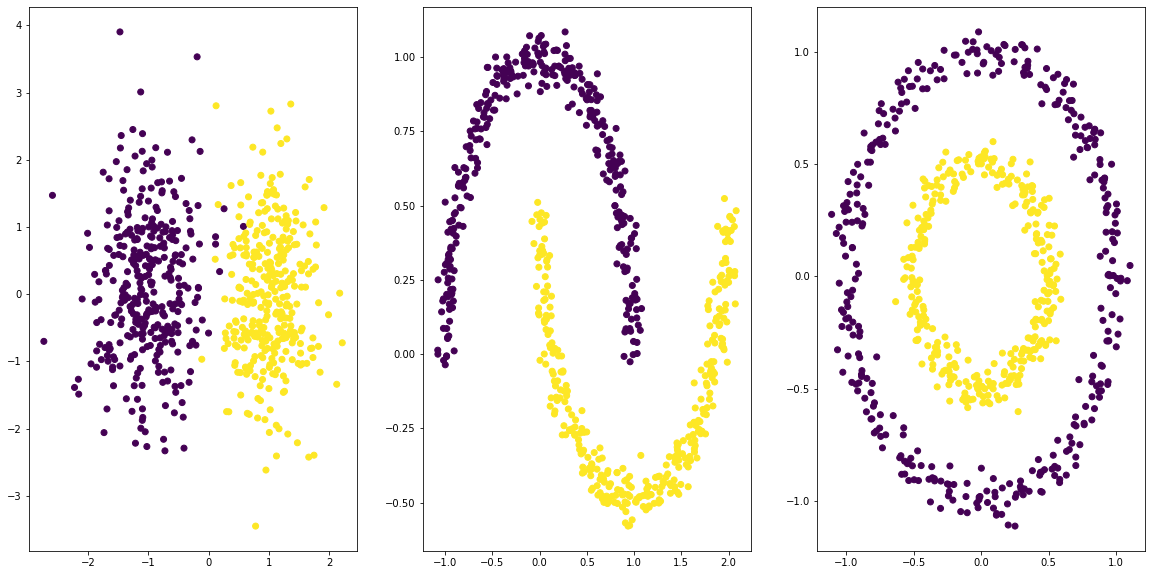

In [2]:
import matplotlib.pyplot as plt
x1, x2, y1, y2 = Make_classification(1000).data_split()
x1_moon, x2_moon, y1_moon, y2_moon = Make_moons(1000).data_split()
x1_circles, x2_circles, y1_circles, y2_circles = Make_circles(1000).data_split()

print(sklearn_logreg(x1, y1, x2, y2), sklearn_logreg(x1_moon, y1_moon, x2_moon, y2_moon), sklearn_logreg(x1_circles, y1_circles, x2_circles, y2_circles))

f, (ax_cla, ax_moon, ax_circle) = plt.subplots(1,3, figsize=(20, 10))
ax_cla.scatter(x1[:,0], x1[:,1], c = y1)
ax_moon.scatter(x1_moon[:,0], x1_moon[:,1], c = y1_moon)
ax_circle.scatter(x1_circles[:,0], x1_circles[:,1], c = y1_circles)

In [3]:
import torch
from torch import nn
from tqdm import tqdm
X_train, X_test = torch.Tensor(x1),torch.Tensor(x2)
y_train, y_test = torch.Tensor(y1),torch.Tensor(y2)
X_train_m, X_test_m = torch.Tensor(x1_moon),torch.Tensor(x2_moon)
y_train_m, y_test_m = torch.Tensor(y1_moon),torch.Tensor(y2_moon)
X_train_c, X_test_c = torch.Tensor(x1_circles),torch.Tensor(x2_circles)
y_train_c, y_test_c = torch.Tensor(y1_circles),torch.Tensor(y2_circles)

In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(2, 1) # Two inputs x1 and x2, Single binary output 
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

def Nonlinear():
    return nn.Sequential(
        nn.Linear(2, 5),
        nn.ReLU(),
        nn.Linear(5, 1, bias=True),
        nn.Sigmoid(),
    )

def LogisticReg_NN(X_train, X_test, y_train, y_test):

    learning_rate = 0.01
    losses_test = []
    acu = []
    model = LogisticRegression()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    iter = 0
    for epoch in tqdm(range(10000),desc='Training Epochs'):
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss = criterion(torch.squeeze(outputs), y_train) 
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        iter+=1
        with torch.no_grad(): # Calculating the loss and accuracy for the test dataset
            outputs_test = torch.squeeze(model(X_test)) #linear model 输出 0-1的值
            loss_test = criterion(outputs_test, y_test) #损失值
            predicted_test = outputs_test.round().detach().numpy() #改回0, 1结果

            total_test = y_test.size(0) #多少个y 测试值
            correct_test = np.sum(predicted_test == y_test.detach().numpy()) #我们预测的结果和y是否相符
            accuracy_test = 100 * correct_test/total_test #准确率

            acu.append(accuracy_test)
            losses_test.append(loss_test.item()) #tensor 需要用item() 提取 保存损失值，方便绘图
    return losses_test, acu

In [5]:
loss_of_classi, acu_of_classi = LogisticReg_NN(X_train, X_test, y_train, y_test)
loss_of_moon, acu_of_moon = LogisticReg_NN(X_train_m, X_test_m, y_train_m, y_test_m)
loss_of_circle, acu_of_circle = LogisticReg_NN(X_train_c, X_test_c, y_train_c, y_test_c)

Training Epochs: 100%|██████████| 10000/10000 [00:05<00:00, 1762.65it/s]


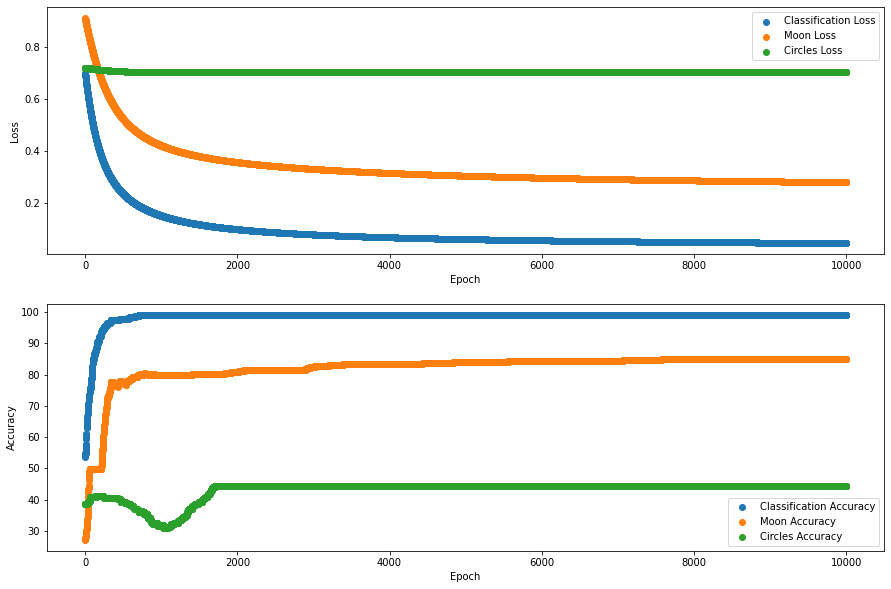

In [6]:
x = range(10000)
f, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 10))
ax1.scatter(x, loss_of_classi, label = 'Classification Loss')
ax1.scatter(x, loss_of_moon, label = 'Moon Loss')
ax1.scatter(x, loss_of_circle, label = 'Circles Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.scatter(x, acu_of_classi, label = 'Classification Accuracy')
ax2.scatter(x, acu_of_moon, label = 'Moon Accuracy')
ax2.scatter(x, acu_of_circle, label = 'Circles Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

In [7]:
##Try Nonlinear 
def Nonlinear_NN(X_train, X_test, y_train, y_test):

    learning_rate = 0.01
    losses_test = []
    acu = []
    model = Nonlinear()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    iter = 0
    for epoch in tqdm(range(10000),desc='Training Epochs'):
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss = criterion(torch.squeeze(outputs), y_train) 
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        iter+=1
        with torch.no_grad(): # Calculating the loss and accuracy for the test dataset
            outputs_test = torch.squeeze(model(X_test)) #linear model 输出 0-1的值
            loss_test = criterion(outputs_test, y_test) #损失值
            predicted_test = outputs_test.round().detach().numpy() #改回0, 1结果

            total_test = y_test.size(0) #多少个y 测试值
            correct_test = np.sum(predicted_test == y_test.detach().numpy()) #我们预测的结果和y是否相符
            accuracy_test = 100 * correct_test/total_test #准确率

            acu.append(accuracy_test)
            losses_test.append(loss_test.item()) #tensor 需要用item() 提取 保存损失值，方便绘图
    return losses_test, acu

In [8]:
loss_of_classi, acu_of_classi = Nonlinear_NN(X_train, X_test, y_train, y_test)
loss_of_moon, acu_of_moon = Nonlinear_NN(X_train_m, X_test_m, y_train_m, y_test_m)
loss_of_circle, acu_of_circle = Nonlinear_NN(X_train_c, X_test_c, y_train_c, y_test_c)

Training Epochs: 100%|██████████| 10000/10000 [00:07<00:00, 1284.35it/s]


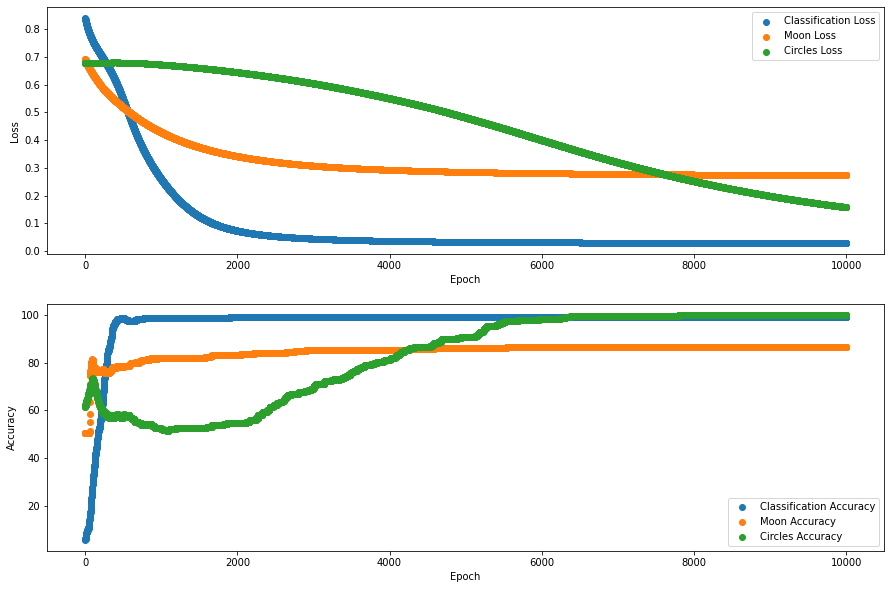

In [9]:
x = range(10000)
f, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 10))
ax1.scatter(x, loss_of_classi, label = 'Classification Loss')
ax1.scatter(x, loss_of_moon, label = 'Moon Loss')
ax1.scatter(x, loss_of_circle, label = 'Circles Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.scatter(x, acu_of_classi, label = 'Classification Accuracy')
ax2.scatter(x, acu_of_moon, label = 'Moon Accuracy')
ax2.scatter(x, acu_of_circle, label = 'Circles Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')